In [1]:
import ast
import itertools
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.spatial import distance
import spacy

from tqdm.notebook import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
verb_relations = pd.read_csv("../data/vg_relations.csv", index_col=0)
verb_relations.head()

,scene_id,verb_synset,subject_id,object_id
0,1,wear.v.01,1058529,1058525
1,1,have.v.01,5049,5050
2,1,have.v.01,1058529,1058511
3,1,have.v.01,1058515,5060
4,1,have.v.01,1058529,1058518


In [3]:
frames = pd.read_csv("../data/frames.csv", index_col=0)
frames.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,caption,img,lemma,children_str
1,sierra looked stunning in this top and this sk...,http://78.media.tumblr.com/3b133294bdc7c7784b7...,look,nsubj _ acomp prep:in advcl
4,cybernetic scene isolated on white background .,https://thumb1.shutterstock.com/display_pic_wi...,isolate,nsubj _ prep:on
5,gangsta rap artist attends sports team vs play...,https://media.gettyimages.com/photos/jayz-atte...,attend,nsubj _ dobj prep:vs
8,# of the sports team skates against sports tea...,https://media.gettyimages.com/photos/bryan-mcc...,skate,nsubj _ prep:against prep:during
10,a flight was traveling when the animal got fre...,http://i.dailymail.co.uk/i/pix/2016/08/10/15/3...,travel,nsubj aux _ advcl


## Preprocessing

We replicate the preprocessing steps from the search script.

In [4]:
# Strip sense information from VG labels.
verb_relations["verb"] = verb_relations.verb_synset.str.split(".").str[0]

IGNORE_VERBS = ["be", "have"]
verb_relations = verb_relations[~verb_relations.verb.isin(IGNORE_VERBS)]

# Drop infrequent verbs.
verb_freq_thresh = 30
vg_verb_counts = verb_relations.verb.value_counts()
drop_verbs = vg_verb_counts[vg_verb_counts < verb_freq_thresh].index
verb_relations = verb_relations[~verb_relations.verb.isin(drop_verbs)]

# Drop scenes with few labels.
scene_freq_thresh = 10
vg_scene_counts = verb_relations.scene_id.value_counts()
drop_scenes = vg_scene_counts[vg_scene_counts < scene_freq_thresh].index
verb_relations = verb_relations[~verb_relations.scene_id.isin(drop_scenes)]

# Drop frames with few verbs.
frame_freq_thresh = 100
frame_counts = frames.children_str.value_counts()
drop_frames = frame_counts[frame_counts < frame_freq_thresh].index
frames = frames[~frames.children_str.isin(drop_frames)]

In [5]:
# Calculate co-occurrence data.
agg_func = sum
frame_cooccurrences = pd.get_dummies(frames.children_str).groupby(frames.lemma).apply(agg_func)

In [6]:
scene_cooccurrences = pd.get_dummies(verb_relations.scene_id).groupby(verb_relations.verb).apply(agg_func)

In [7]:
def get_cooccurrences_for(cooccurrences, verbs, freq_thresh=2):
    """
    Extract relevant rows and columns for `verbs` from a co-occurrence matrix,
    consisting of verbs along the index and contexts along the columns. Returns
    a dataframe view where each column has nonzero total occurrences for some
    verb.
    """
    df = cooccurrences.loc[list(verbs)]
    drop_columns = df.columns[df.min(axis=0) < freq_thresh]
    return df.drop(columns=drop_columns)

In [8]:
get_cooccurrences_for(frame_cooccurrences, ["milk", "wear"])

,_ dobj,_ dobj prep:on,nsubj _ dobj,nsubj _ dobj prep:at,nsubj _ dobj prep:in,nsubj _ dobj prep:on
lemma,,,,,,
milk,3,3,11,3,2,6
wear,131,20,1885,177,228,239


In [9]:

# TOOL: look up frame cooccurrence metric and score frame pairs for arbitrary verb combinations

v1, v2 = "milk", "wear"
c = frame_cooccurrences.loc[[v1, v2]]
c = c.drop(columns=c.columns[c.min(axis=0) < 3])
old_c = c.copy()

c = c.div(c.sum(axis=1), axis=0)
c = c.div(c.sum(axis=0), axis=1)
c.loc["metric"] = c.loc[v1] * (1 - c.loc[v1])
c = c.sort_values("metric", axis=1)
c[c.columns[:20]]

,_ dobj prep:on,nsubj _ dobj prep:on,_ dobj,nsubj _ dobj,nsubj _ dobj prep:at
lemma,,,,,
milk,0.933977,0.703049,0.683516,0.354979,0.615153
wear,0.066023,0.296951,0.316484,0.645021,0.384847
metric,0.061664,0.208771,0.216322,0.228969,0.236740


----

In [10]:
import requests
from IPython.display import display, HTML

def build_frame_html(verbs, frame_strs, examples_per_verb=2):
    # Pre-fetch sentences from frames df
    frames_data = frames[(frames.lemma.isin(verbs)) & (frames.children_str.isin(frame_strs))].set_index(["lemma", "children_str"])
    
    # Pre-fetch co-occurrence data and normalize
    norm_cooc = frame_cooccurrences.loc[list(verbs)]
    norm_cooc = norm_cooc.div(norm_cooc.sum(axis=1), axis=0)
    
    html = ["<table style='max-width: 40em'>"]
    for frame_str in frame_strs:
        html.append(f"<tr style='font-weight: bold; font-family: monospace'><td colspan='3'>{frame_str}</td></tr>")
        
        # Retrieve example sentences.
        for verb in verbs:
            try:
                verb_exs = frames_data.loc[verb, frame_str]
            except:
                html.append(f"<tr><td>{verb}</td><td>----</td><td></td></tr>")
                continue
                
            verb_exs = list(zip(range(examples_per_verb), verb_exs.iterrows()))
            
            # Truncate relative frequency
            rel_freq = norm_cooc.loc[verb][frame_str]
            rel_freq = "%.4f" % rel_freq
            
            for i, (_, verb_ex) in verb_exs:
                sentence = verb_ex.caption.replace(verb, f"<strong>{verb}</strong>")
                if i == 0:
                    td_tag = f"<td rowspan={len(verb_exs)}>{verb}</td><td rowspan={len(verb_exs)}>{rel_freq}</td><td>"
                else:
                    td_tag = "<td>"
                html.append(f"<tr>{td_tag}{sentence}</td></tr>")
                
    html.append("</table>")
    return "".join(html)

def build_scene_html(scene_ids):
    html = ["<table><tr><th>Image</th><th>Labels</th></tr>"]
    scene_ids = np.random.choice(scene_ids, replace=False, size=min(20, len(scene_ids)))
        
    for scene_id in scene_ids:
        # Get mentioned verbs.
        scene_verbs = verb_relations[verb_relations.scene_id == scene_id].verb_synset.value_counts()
        scene_verbs_html = pd.DataFrame(scene_verbs.sort_values(ascending=False).head(10)).to_html(header=False, index=True)
        
        metadata = requests.get(f"https://visualgenome.org/api/v0/images/{scene_id}?format=json").json()
        
        # Prepare a spreadsheet cell content for easy copy-paste.
        cell_label = f"=HYPERLINK(\"{metadata['url']}\";\"{scene_id}\")"

        html.append(f"<tr><td><div style='font-family: monospace; width: 15em; overflow-wrap: break-word'>{cell_label}</div><img src='{metadata['url']}' style='display: inline; width: 200px; margin: 1px' /></td>"
                    + "<td>" + scene_verbs_html + "</td></tr>")
        
    html.append("</table>")
    return "".join(html)
                    
def plot_search_row(row):
    scene_html = build_scene_html(row.scene_set)
    frame_html = build_frame_html([row.verb1, row.verb2], row.frame_set)
    
    html = f"<div><div style='float: left; margin: 10px;'>{scene_html}</div>"
    html += f"<div style='float: left; margin: 10px;'>{frame_html}</div></div>"
    return display(HTML(html))

------

In [11]:
items_df = pd.read_csv("../materials/items.csv", index_col=["item_idx", "scene", "verb"])
items_df.head()

frame       sentence_left verb_form  \
item_idx scene   verb                                                           
1        2377225 arrive        nsubj _ prep:for    [the] train [is]  arriving   
         2407876 arrive         nsubj _ prep:at    [the] train [is]  arriving   
         2377225 pull              nsubj _ dobj  [the] horses [are]   pulling   
         2407876 pull    nsubj _ dobj prep:into    [the] train [is]   pulling   
2        2343305 arrive        nsubj _ prep:for    [the] train [is]  arriving   

                        verb_form_tag          sentence_right Comments  
item_idx scene   verb                                                   
1        2377225 arrive           VBG    [for] [the] settlers      NaN  
         2407876 arrive           VBG      [at] [the] station      NaN  
         2377225 pull             VBG            [the] people      NaN  
         2407876 pull             VBG    [into] [the] station      NaN  
2        2343305 arrive           VBG  [for] [the] passengers      NaN

In [12]:
train_df = pd.read_csv("../data/train_results.csv", index_col=["trial_index", "uniqueid"])
test_df = pd.read_csv("../data/test_results.csv", index_col=["trial_index", "uniqueid"])

----

## Postdiction analysis

Name of the game for this section: try to compute some metric over the provided frame information which postdicts meaning judgment behavior.

### Local frame variance

Try to postdict whether per-chunk responses will be correct based on the variance of the distributions `p(verb | frame)` for the frames presented in each chunk.

In [13]:
def get_row_local_frame_variances(row):
    coocs = get_cooccurrences_for(frame_cooccurrences, eval(row.verb_sequence))
    
    # Look up relevant item, and get the frames that were presented
    frames = []
    for verb, verb_frames in items_df.loc[row.item_idx].groupby("verb")["frame"]:
        frames.extend(verb_frames)
        
    # Fix formatting difference, derp
    coocs.columns = [c.strip() for c in coocs.columns]
    
    # Avoid KeyErrors
    old_frames = set(frames)
    frames = set(frames) & set(coocs.columns)
    if len(old_frames - frames) > 0:
        print("DROPPING for verbs %s: %s" % (row.verb_sequence, old_frames - frames))
        
    if len(frames) == 0:
        raise ValueError("no frame matches, yikes")
    
    # Retrieve relevant coocs
    coocs = coocs[frames]
    
    # Normalize so that each column is a distribution over the two verbs.
    coocs = coocs.div(coocs.sum(axis=0), axis=1)
    
    # Calculate per-frame variance
    variances = coocs.apply(lambda frame_ps: frame_ps.iloc[0] * (1 - frame_ps.iloc[0]))
    
    return variances
    
test_df["local_frame_variance"] = test_df.progress_apply(lambda row: get_row_local_frame_variances(row).sum(), axis=1)

DROPPING for verbs ['pull', 'arrive']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['pull', 'arrive']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['watch', 'swing']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['watch', 'swing']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['arrive', 'pull']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['arrive', 'pull']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['swing', 'watch']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['swing', 'watch']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['wear', 'jump']: {'nsubj _ prep:down'}
DROPPING for verbs ['wear', 'jump']: {'nsubj _ prep:down'}
DROPPING for verbs ['stand', 'carry']: {'nsubj _ prep:with'}
DROPPING for verbs ['stand', 'carry']: {'nsubj _ prep:with'}
DROPPING for verbs ['wear', 'run']: {'nsubj _ prep:by'}
DROPPING for verbs ['wear', 'run']: {'nsubj _ prep:by'}
DROPPING for verbs ['run', 'wear']: {'nsubj _ prep:by'}
DROPPING for verbs ['run', 'wear']: {'nsubj 

In [14]:
test_df.head()

condition  \
trial_index uniqueid                                                  
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z      verb   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z      verb   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z      verb   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z      verb   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z      verb   

                                                           counterbalance  \
trial_index uniqueid                                                        
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z               0   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z               0   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z               0   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z               0   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z               0   

                                                                             assignmentId  \
trial_index uniqueid                                                                        
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   

                                                                 workerId  \
trial_index uniqueid                                                        
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  A1YFVXP4A1CXSF   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  A1YFVXP4A1CXSF   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  A1YFVXP4A1CXSF   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  A1YFVXP4A1CXSF   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  A1YFVXP4A1CXSF   

                                                                                    hitId  \
trial_index uniqueid                                                                        
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3VJ4PFXFJ3V93T2IDPJKWUVQ3Y8UAY   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3VJ4PFXFJ3V93T2IDPJKWUVQ3Y8UAY   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3VJ4PFXFJ3V93T2IDPJKWUVQ3Y8UAY   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3VJ4PFXFJ3V93T2IDPJKWUVQ3Y8UAY   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  3VJ4PFXFJ3V93T2IDPJKWUVQ3Y8UAY   

                                                                    trial_type  \
trial_index uniqueid                                                             
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  survey-multi-choice   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  survey-multi-choice   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  survey-multi-choice   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  survey-multi-choice   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  survey-multi-choice   

                                                              rt  \
trial_index uniqueid                                               
6           A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  21217   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  21217   
10          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   7089   
            A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z   7089   
14          A1YFVXP4A1CXSF:3OJSZ2ATDTKDMWCYVN4U2BX8IGX57Z  11729   

                                                          internal_node_id  \
trial_index uniqueid                          

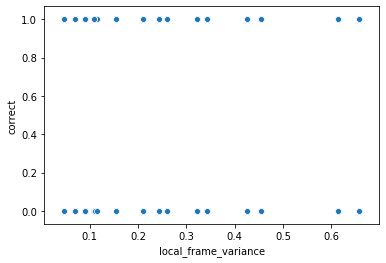

In [15]:
sns.scatterplot(data=test_df[test_df.condition == "syntax"], x="local_frame_variance", y="correct")

#### Predicting probabilities on the item level instead

Try to predict on the item level instead. Trying to see through the noise here.

On the item level, what is the relation between `p(correct | presented frames)` and the variance metric ?

In [16]:
df = pd.DataFrame(test_df[test_df.condition == "syntax"].groupby(["item_idx", "verb_sequence"]).correct.agg(["mean", "std"]).reset_index())
df["local_frame_variance"] = df.progress_apply(lambda row: get_row_local_frame_variances(row).sum(), axis=1)

DROPPING for verbs ['arrive', 'pull']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['pull', 'arrive']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['run', 'wear']: {'nsubj _ prep:by'}
DROPPING for verbs ['wear', 'run']: {'nsubj _ prep:by'}
DROPPING for verbs ['jump', 'wear']: {'nsubj _ prep:down'}
DROPPING for verbs ['wear', 'jump']: {'nsubj _ prep:down'}
DROPPING for verbs ['carry', 'stand']: {'nsubj _ prep:with'}
DROPPING for verbs ['stand', 'carry']: {'nsubj _ prep:with'}
DROPPING for verbs ['swing', 'watch']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['watch', 'swing']: {'nsubj _ prep:at prep:during'}



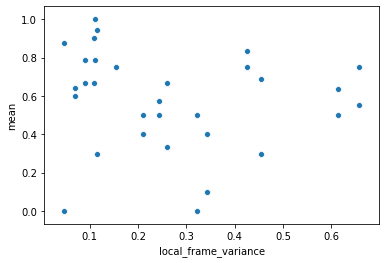

In [17]:
sns.scatterplot(data=df, x="local_frame_variance", y="mean")

### Explicit probability

Why don't we consider an explicit probability model for the subjects' prediction problem. After being presented with a series of verbs in frames, we have to perform a 2AFC for each nonced verb. One way that 2AFC might go over is through the categorical

$$p(verb_i \to nonce_i \mid frames) = \left(\prod_j p(verb_i \mid obs\_frame_j)\right) \left(\prod_k (1 - p(verb_i \mid alt\_frame_k)\right)$$

Let's compute this belief for each verb, and see whether it predicts the verb the subject will choose. Here $verb_i \to nonce_i$ is equivalent to asking whether the pair is correctly predicted. So we'll match `correct ~ the_metric`.

In [18]:
def get_row_local_probs(row):
    coocs = get_cooccurrences_for(frame_cooccurrences, eval(row.verb_sequence))
    
    # Fix formatting difference, derp
    coocs.columns = [c.strip() for c in coocs.columns]

    query_verb = eval(row.verb_sequence)[row.survey_question_idx]
    # For this queried verb, get p(verb | frames).
    
    # Look up relevant item, and get the frames that were presented
    frames = set(items_df.loc[row.item_idx].xs(query_verb, level="verb")["frame"])
    
    # Avoid KeyErrors
    old_frames = set(frames)
    frames = set(frames) & set(coocs.columns)
    if len(old_frames - frames) > 0:
        print("DROPPING for verbs %s: %s" % (row.verb_sequence, old_frames - frames))
        
    if len(frames) == 0:
        raise ValueError("no frame matches, yikes")
    
    # Normalize so that each column is a distribution over the two verbs.
    probs = coocs.div(coocs.sum(axis=0), axis=1)
    
    # Retrieve relevant probabilities
    probs = probs[frames]
    
    # Get log-probability of query verb: p(verb | used frames) * p(not verb | other frames)
    logp = np.log(probs.loc[query_verb]).sum()
    logp += np.log(1 - probs.drop(index=[query_verb])).sum().sum()
    
    return logp
 
test_df["local_prob"] = test_df.progress_apply(get_row_local_probs, axis=1)

DROPPING for verbs ['pull', 'arrive']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['watch', 'swing']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['arrive', 'pull']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['swing', 'watch']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['wear', 'jump']: {'nsubj _ prep:down'}
DROPPING for verbs ['stand', 'carry']: {'nsubj _ prep:with'}
DROPPING for verbs ['wear', 'run']: {'nsubj _ prep:by'}
DROPPING for verbs ['run', 'wear']: {'nsubj _ prep:by'}
DROPPING for verbs ['watch', 'swing']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['swing', 'watch']: {'nsubj _ prep:at prep:during'}
DROPPING for verbs ['arrive', 'pull']: {'nsubj _ dobj prep:into'}
DROPPING for verbs ['run', 'wear']: {'nsubj _ prep:by'}
DROPPING for verbs ['carry', 'stand']: {'nsubj _ prep:with'}
DROPPING for verbs ['stand', 'carry']: {'nsubj _ prep:with'}
DROPPING for verbs ['jump', 'wear']: {'nsubj _ prep:down'}
DROPPING for verbs ['run', 'wear']: {'nsubj _ pre

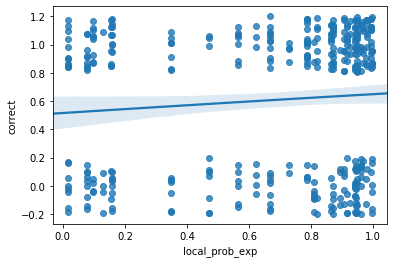

In [19]:
test_df["local_prob_exp"] = np.exp(test_df.local_prob)
sns.regplot(data=test_df[test_df.condition == "syntax"], x="local_prob_exp", y="correct",
            y_jitter=0.2, logistic=True)

```
Generalized linear mixed model fit by maximum likelihood (Laplace Approximation) ['glmerMod']
 Family: binomial  ( logit )
Formula: correct ~ local_prob + (1 | uniqueid) + (1 | item_idx:survey_question_idx)
   Data: df

     AIC      BIC   logLik deviance df.resid 
   926.9    945.0   -459.4    918.9      686 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6095 -0.9342  0.5223  0.7618  1.5034 

Random effects:
 Groups                       Name        Variance Std.Dev.
 uniqueid                     (Intercept) 0.69266  0.8323  
 item_idx:survey_question_idx (Intercept) 0.01005  0.1003  
Number of obs: 690, groups:  uniqueid, 115; item_idx:survey_question_idx, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.39565    0.13002   3.043  0.00234 **
local_prob   0.08871    0.08445   1.050  0.29349   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
local_prob 0.451
```